In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('tesla-stock-price.csv')
df.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
5,7/7/2010,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
6,7/8/2010,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
7,7/9/2010,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
8,7/12/2010,17.950001,18.070000,17.000000,17.049999,2202500,17.049999
9,7/13/2010,17.389999,18.639999,16.900000,18.139999,2680100,18.139999


In [3]:
df.shape

(1692, 7)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [5]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2010-06-29,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


D:\anaconda\envs\TensorFlowGPU\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


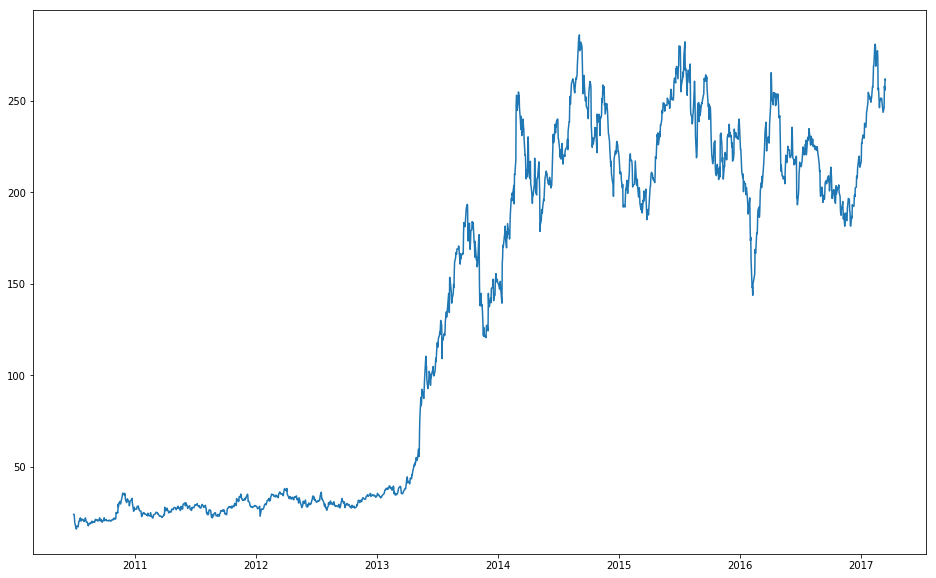

In [6]:
#plot
plt.figure(figsize=(16,10))
plt.plot(df['Close'], label='Close Price history')

In [7]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [8]:
# making a new dataset for performing actions on it so the original dataset will not change
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Close'][i] = df['Close'][i]
    
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True) 
new_data.head()

,Close
Date,
2010-06-29,23.89
2010-06-30,23.83
2010-07-01,21.96
2010-07-02,19.2
2010-07-06,16.11


In [9]:
data = new_data.values

train = data[0:1353,:]
test = data[1353:,:]

In [10]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

D:\anaconda\envs\TensorFlowGPU\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
#converting dataset into x_train and y_train
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [12]:
# making the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs=1, batch_size=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1293/1293 [==============================] - 201s 155ms/step - loss: 0.0041


In [14]:
#predicting values
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [15]:
# creating test set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [16]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

D:\anaconda\envs\TensorFlowGPU\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


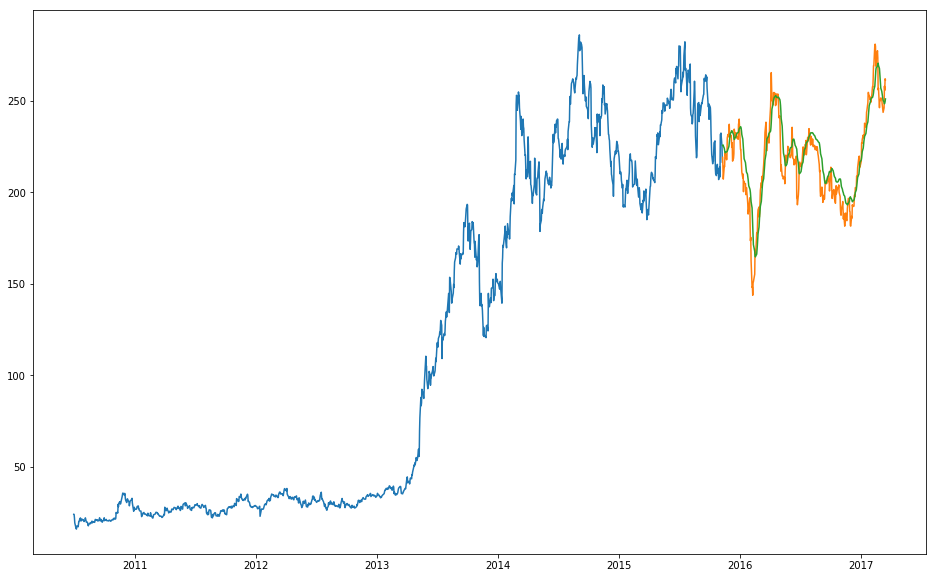

In [17]:
#for plotting LSTM results

plt.figure(figsize=(16,10))
train = new_data[:1353]
test = new_data[1353:]
test['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])